# Spam Email Classification Using Semi-Supervised Leanrning

### Prepared By: 
1. Bahauddin Kalyani - C0886857
2. Dev Makwana - C0885064
3. Krina Patel - C0886861
4. Mahaveersinh Chauhan - C0884854
5. Trushna Patel - C0886910

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.datasets import load_files
import nltk
import unicodedata
import random
from sklearn import semi_supervised
from sklearn import svm
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

### Data Collection

In [2]:
# Combine And Load Emails from Different Directories
# Sepreate Emails and Labels

Emails , Labels = [] , []

for i in range(1,7):
    emails = load_files(f'enron{i}')
    Emails = np.append(Emails, emails.data)
    Labels = np.append(Labels, emails.target)
    
Classes = emails.target_names

In [3]:
# Verifying Shape and Looking at Data

print(f"Emails.shape: {Emails.shape:}")
print(f"Labels.shape: {Labels.shape}")
print("\n")
print(f"Example Emails[0]: \n\n {Emails[0]}")
print("\n")
print(f"Classe Labels[0]: \n\n {Labels[0]} ({Classes[int(Labels[0])]})")

Emails.shape: (33715,)
Labels.shape: (33715,)


Example Emails[0]: 

 b'Subject: nesa / hea \' s 24 th annual meeting\r\nsaddle up for nesa / hea \' s 24 th annual meeting\r\n" deep in the heart of texas "\r\nseptember 9 - 11 , 2001\r\nhyatt regency hill country resort\r\nsan antonio , texas\r\nthe annual meeting planning committee has put together an outstanding\r\nprogram for your review . it is attached below in an adobe acrobat pdf file\r\n- if you have problems with the attachment please call nesa / hea\r\nheadquarters at ( 713 ) 856 - 6525 and we \' ll mail or fax a copy out immediately .\r\ngeneral session topics include :\r\n* will tomorrow \' s restructured electric infrastructure support\r\ntomorrow \' s economy ?\r\n* power deregulation panel : developer / ipp , utility / transmission , power\r\nmarketer , government , retail\r\n* power demand\r\n* the state of the energy industry\r\n* new political administration - impact on energy policy and\r\nenvironment\r\nnetworking op

In [4]:
# Creating a DataFrame of Emails and Labels

Edict = {'Emails' : Emails,
        'Labels' : np.int_(Labels)}
DF = pd.DataFrame(data=Edict)


In [5]:
DF = DF.drop_duplicates().reset_index()

### DataFrame

In [6]:
DF

,index,Emails,Labels
0,0,b'Subject: nesa / hea \' s 24 th annual meetin...,0
1,1,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...,0
2,2,"b""Subject: investor here .\r\nfrom : mr . rich...",1
3,3,"b""Subject: hi paliourg all available meds . av...",1
4,4,b'Subject: january nominations at shell deer p...,0
...,...,...,...
30488,33709,"b""Subject: thats how p / orn stars do it\r\nin...",1
30489,33710,b'Subject: congratulations ! ! ! ! you have wo...,1
30490,33711,"b""Subject: new pharm site new great prices hum...",1
30491,33712,"b""Subject: do you remember us ?\r\n- easily lo...",1


In [7]:
DF.head(10)

,index,Emails,Labels
0,0,b'Subject: nesa / hea \' s 24 th annual meetin...,0
1,1,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...,0
2,2,"b""Subject: investor here .\r\nfrom : mr . rich...",1
3,3,"b""Subject: hi paliourg all available meds . av...",1
4,4,b'Subject: january nominations at shell deer p...,0
5,5,b'Subject: and the final numbers for may are ....,0
6,6,b'Subject: enron / hpl actuals for january 5 -...,0
7,7,"b'Subject: enron / hpl actuals for october 4 ,...",0
8,8,b'Subject: volume increase - hpl meter 68 - 62...,0
9,9,b'Subject: meters with flow and no nom\r\nearl...,0


<AxesSubplot:xlabel='Labels', ylabel='count'>

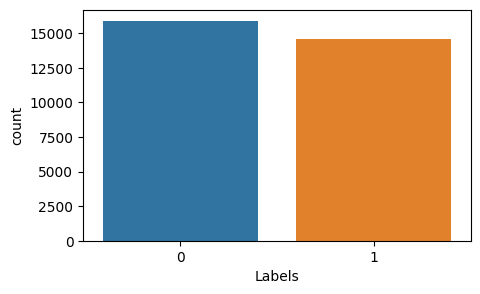

In [8]:
# Count of Spam and Ham emails

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
sns.countplot(x='Labels', data=DF)

### Data Preprocessing

In [9]:
def Stopword(data):
    stop_words =  set(stopwords.words('english'))
    word_tokens = word_tokenize(data)
    sent = [w for w in word_tokens if w not in stop_words and len(w) > 1]
    return ' '.join(sent)


def casefolding(data):
    new_str = data.lower()
    return str(new_str)

def cleaning(data):
    
    # Remove non-ascii
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Remove digits from string
    data = re.sub("\d+", " ", data)
    
    # Remove Hashtag
    data = re.sub("#[^\s]+", "", data)
    
    # Remove Mention
    data = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data)
    
    #Remove additional white spaces
    data = re.sub('[\s]+', ' ', data)
    
    return data

def preprocess(data):
     # tokenization
    tokens = casefolding(data)
    tokens = cleaning(tokens)
    tokens = "".join(tokens)
    
    # listing stopwords from NLTK
    stops = Stopword(tokens)
    
    return stops

In [10]:
DF1 = DF.copy()

In [11]:
DF

,index,Emails,Labels
0,0,b'Subject: nesa / hea \' s 24 th annual meetin...,0
1,1,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...,0
2,2,"b""Subject: investor here .\r\nfrom : mr . rich...",1
3,3,"b""Subject: hi paliourg all available meds . av...",1
4,4,b'Subject: january nominations at shell deer p...,0
...,...,...,...
30488,33709,"b""Subject: thats how p / orn stars do it\r\nin...",1
30489,33710,b'Subject: congratulations ! ! ! ! you have wo...,1
30490,33711,"b""Subject: new pharm site new great prices hum...",1
30491,33712,"b""Subject: do you remember us ?\r\n- easily lo...",1


In [12]:
DF1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30493 entries, 0 to 30492
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   30493 non-null  int64 
 1   Emails  30493 non-null  object
 2   Labels  30493 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 595.7+ KB


In [13]:
DF1['Emails'] = DF1['Emails'].map(lambda x: preprocess(x))

In [14]:
# Dropping the emails having length more than 500
DF1['Emails'].map(lambda x: True if len(x.split()) < 500 else False).value_counts()

True     29206
False     1287
Name: Emails, dtype: int64

In [15]:
DF1 = DF1[DF1['Emails'].map(lambda x: True if len(x.split()) < 500 else False)]

In [16]:
DF2 = DF1.copy()

In [17]:
DF2

,index,Emails,Labels
0,0,subject nesa hea th annual meeting nsaddle nes...,0
1,1,subject meter nov ndaren ncould please resolve...,0
2,2,subject investor nfrom mr richard mayer ndear ...,1
3,3,subject hi paliourg available meds available b...,1
4,4,subject january nominations shell deer park nf...,0
...,...,...,...
30488,33709,subject thats orn stars nincrease cum volume o...,1
30489,33710,subject congratulations ndayzers international...,1
30490,33711,subject new pharm site new great prices humber...,1
30491,33712,subject remember us easily lose body weight in...,1


### Tokenization

In [18]:
# Tokenization

def to_lines(mails):
    all_mails = list(mails)
    return all_mails

def max_len(mails):
    all_mails = to_lines(mails)
    return max(len(d.split()) for d in all_mails)

def create_tokenizer(mails):
    lines = to_lines(mails)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


tokenizer = create_tokenizer(DF1['Emails'])
Max_len = max_len(DF1['Emails'])
Vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size : {Vocab_size} \nTotal Emails : {len(DF1["Emails"])}')
print('Max length among all mails : ', Max_len)

Vocab Size : 148207 
Total Emails : 29206
Max length among all mails :  499


In [19]:
print(tokenizer.word_index)
print(len(tokenizer.word_index))

{'subject': 1, 'ect': 2, 'enron': 3, 'com': 4, 'nto': 5, 'hou': 6, 'nthe': 7, 'please': 8, 'ni': 9, 'nsubject': 10, 'would': 11, 'pm': 12, 'ncc': 13, 'know': 14, 'message': 15, 'us': 16, 'time': 17, 'new': 18, 'get': 19, 'nwe': 20, 'one': 21, 'may': 22, 'nfrom': 23, 'gas': 24, 'information': 25, 'need': 26, 'mail': 27, 'nplease': 28, 'like': 29, 'email': 30, 'business': 31, 'nthanks': 32, 'nthis': 33, 'company': 34, 'vince': 35, 'also': 36, 'day': 37, 'www': 38, 'deal': 39, 'let': 40, 'http': 41, 'nyou': 42, 'nand': 43, 'price': 44, 'energy': 45, 'see': 46, 'contact': 47, 'kaminski': 48, 'corp': 49, 'original': 50, 'th': 51, 'na': 52, 'nif': 53, 'want': 54, 'group': 55, 'free': 56, 'money': 57, 'call': 58, 'data': 59, 'nhttp': 60, 'make': 61, 'date': 62, 'meeting': 63, 'next': 64, 'power': 65, 'nsent': 66, 'nfor': 67, 'number': 68, 'list': 69, 'week': 70, 'forwarded': 71, 'work': 72, 'nvince': 73, 'year': 74, 'risk': 75, 'questions': 76, 'account': 77, 'nin': 78, 'could': 79, 'today': 

In [20]:
def Pad_Sequance(mails):
    Embedded_docs = tokenizer.texts_to_sequences([mails])
    Padded_sequence = pad_sequences(Embedded_docs , maxlen=Max_len)
    
    return Padded_sequence

In [21]:
DF1['Emails'][0]

'subject nesa hea th annual meeting nsaddle nesa hea th annual meeting deep heart texas nseptember nhyatt regency hill country resort nsan antonio texas nthe annual meeting planning committee put together outstanding nprogram review attached adobe acrobat pdf file problems attachment please call nesa hea nheadquarters mail fax copy immediately ngeneral session topics include tomorrow restructured electric infrastructure support ntomorrow economy power deregulation panel developer ipp utility transmission power nmarketer government retail power demand state energy industry new political administration impact energy policy nenvironment nnetworking opportunities opening reception sunday september golf tournament tours area attractions monday september nthe hyatt regency hill country resort limited block rooms available nfor nesa hea members guests sure check page lodging ninformation make reservation soon possible nwe hope take opportunity meet colleagues ncustomers relaxing yet professio

In [22]:
DF1['Emails'] = tokenizer.texts_to_sequences(DF1['Emails'])

In [23]:
DF1

,index,Emails,Labels
0,0,"[1, 3694, 2778, 51, 1431, 63, 38089, 3694, 277...",0
1,1,"[1, 148, 999, 564, 1617, 8, 2570, 339, 1608, 8...",0
2,2,"[1, 1601, 23, 347, 688, 18501, 226, 1001, 9, 3...",1
3,3,"[1, 1472, 1541, 93, 618, 93, 32854, 72763, 328...",1
4,4,"[1, 324, 2041, 2924, 7377, 1570, 603, 1103, 13...",0
...,...,...,...
30488,33709,"[1, 9329, 15733, 4721, 2915, 2579, 302, 5988, ...",1
30489,33710,"[1, 1509, 17289, 238, 940, 113, 1462, 66967, 1...",1
30490,33711,"[1, 18, 7531, 102, 18, 159, 118, 71230, 10774,...",1
30491,33712,"[1, 752, 16, 2103, 1011, 950, 1056, 456, 1679,...",1


In [24]:
y_orig = DF1['Labels'].copy()

rng = np.random.RandomState(0)
unl_pts = rng.rand(DF1['Labels'].shape[0]) < 0.6

DF1.Labels[unl_pts] = -1

c:\users\chauh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
print((DF1['Labels']))
type(DF1['Labels'])

0       -1
1        0
2        1
3       -1
4       -1
        ..
30488   -1
30489   -1
30490   -1
30491    1
30492   -1
Name: Labels, Length: 29206, dtype: int32


pandas.core.series.Series

In [26]:
seq =  np.array([a[0] for a in DF1['Emails']])
seq = seq.reshape(-1, 1)

In [27]:
test_seq = np.array(DF1['Labels']).reshape(-1, 1)

### Semi Supervised Learning - SelfTrainingClassifier using SVC

In [28]:
model1 = svm.SVC(probability=True)
lbl = semi_supervised.SelfTrainingClassifier(model1)

lbl.fit(seq, test_seq)

c:\users\chauh\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelfTrainingClassifier(base_estimator=SVC(probability=True))

In [29]:
y_pred = lbl.predict(seq)
print("Predicted Labels:", y_pred)

Predicted Labels: [0 0 0 ... 0 0 0]


In [30]:
accuracy = metrics.accuracy_score(y_orig, y_pred)
print("Accuracy score: ", accuracy)

Accuracy score:  0.525645415325618


[[15352     0]
 [13854     0]]


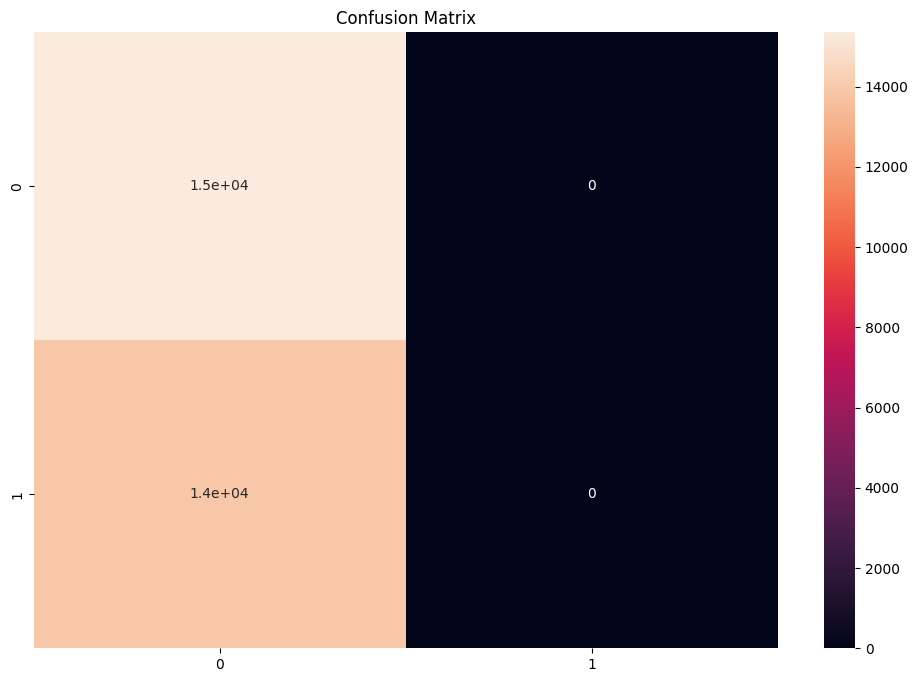

In [36]:
cm=confusion_matrix(y_orig,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
print(cm)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer() 
X =  cv.fit_transform(DF2['Emails'])

### Semi Supervised Learning - SelfTrainingClassifier using Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()

lbl1 = semi_supervised.SelfTrainingClassifier(gnb)

lbl1.fit(seq, test_seq)

c:\users\chauh\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelfTrainingClassifier(base_estimator=MultinomialNB())

In [39]:
y_pred = lbl.predict(seq)
print("Predicted Labels:", y_pred)

Predicted Labels: [0 0 0 ... 0 0 0]


In [40]:
accuracy = metrics.accuracy_score(y_orig, y_pred)
print("Accuracy score: ", accuracy)

Accuracy score:  0.525645415325618


[[15352     0]
 [13854     0]]


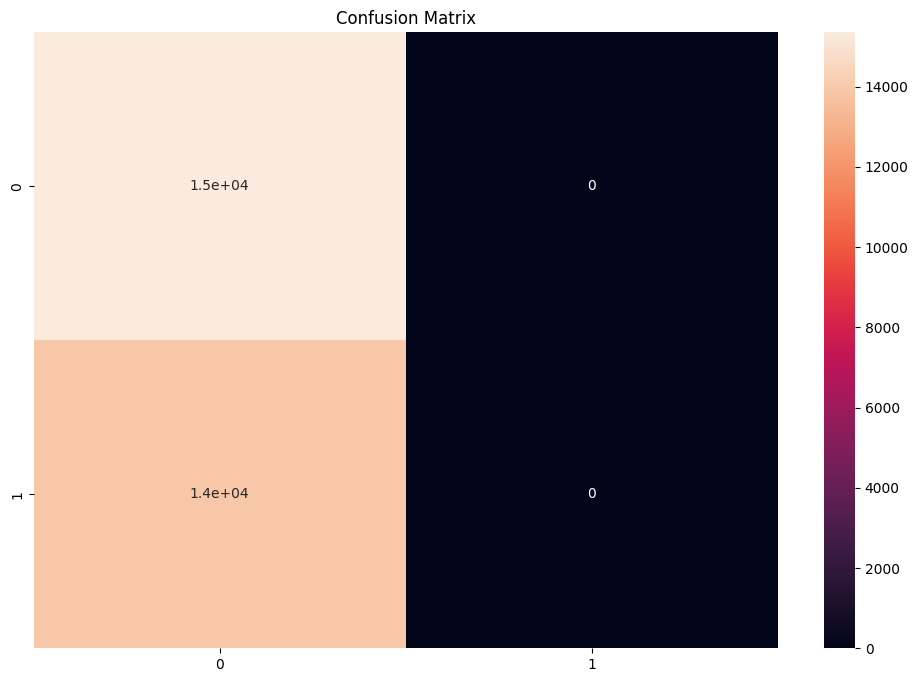

In [41]:
cm=confusion_matrix(y_orig,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
print(cm)

# Train, Test split

In [42]:
tokenizer = create_tokenizer(DF2['Emails'])
Max_len = max_len(DF2['Emails'])
Vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size : {Vocab_size} \nTotal Emails : {len(DF2["Emails"])}')
print('Max length among all mails : ', Max_len)

# Applying pad sequance on whole column
DF2['Emails'] = DF2['Emails'].map(lambda x: Pad_Sequance(x))

Vocab Size : 148207 
Total Emails : 29206
Max length among all mails :  499


In [43]:
from sklearn.model_selection import train_test_split  

X_labeled_train, X_unlabeled_test, y_labeled_train, y_unlabeled_test = train_test_split(DF2['Emails'], DF2['Labels'], train_size=0.3, shuffle=True)

In [44]:
# Resetting the index of unlabeled data

X_unlabeled_test = X_unlabeled_test.reset_index().drop('index', axis=1)

### LSTM Model Bulding and Training

In [45]:
# Model

from tensorflow.keras.optimizers import Adam

Model = Sequential()
Model.add(Embedding(input_dim=Vocab_size , output_dim=128, input_length=Max_len))
Model.add(Dropout(0.25))
Model.add(LSTM(256))
Model.add(Dropout(0.2))
Model.add(Dense(1 , activation='sigmoid'))

In [46]:
# Model colpilation


Model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [47]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 499, 128)          18970496  
_________________________________________________________________
dropout (Dropout)            (None, 499, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 19,364,993
Trainable params: 19,364,993
Non-trainable params: 0
_________________________________________________________________


##### Initial Model training with only 30% of data

In [48]:
Pad_Seq = np.array([a[0] for a in X_labeled_train.values])

In [49]:
Pad_Seq.shape

(8761, 499)

In [50]:
History = Model.fit(Pad_Seq , y_labeled_train , validation_split=0.1 , epochs = 5 , batch_size = 64)

Epoch 1/5
124/124 [==============================] - 398s 3s/step - loss: 0.3069 - accuracy: 0.8867 - val_loss: 0.0934 - val_accuracy: 0.9704
Epoch 2/5
124/124 [==============================] - 462s 4s/step - loss: 0.0354 - accuracy: 0.9904 - val_loss: 0.1058 - val_accuracy: 0.9590
Epoch 3/5
124/124 [==============================] - 358s 3s/step - loss: 0.0171 - accuracy: 0.9963 - val_loss: 0.0646 - val_accuracy: 0.9749
Epoch 4/5
124/124 [==============================] - 364s 3s/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0652 - val_accuracy: 0.9806
Epoch 5/5
124/124 [==============================] - 372s 3s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0796 - val_accuracy: 0.9761


[[    0 15352]
 [13854     0]]


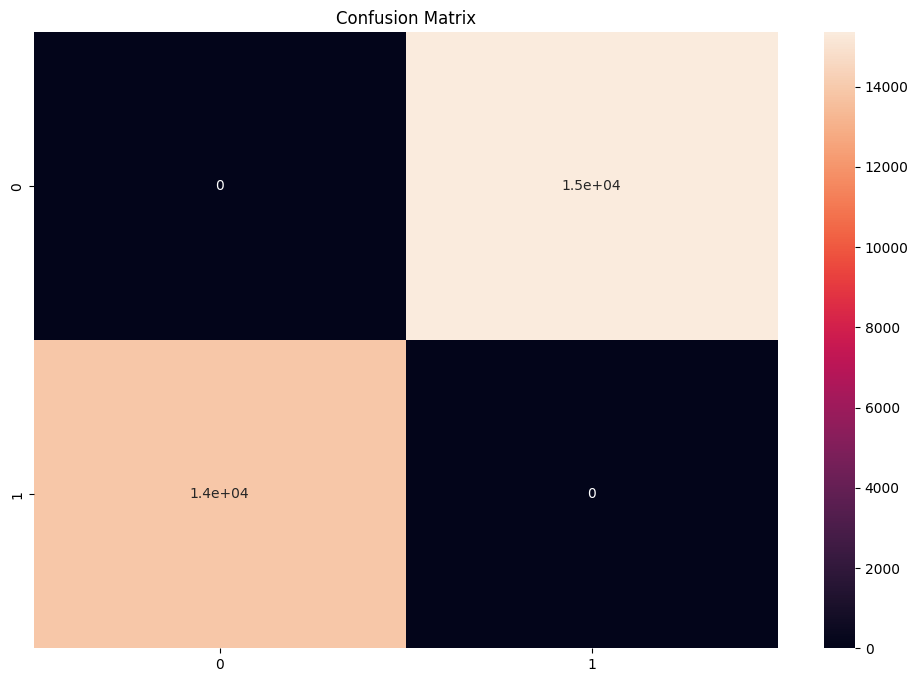

In [57]:
y_pred = Model.predict(y_orig)
Y_pr = [1 if float(a) > 0.5 else 0 for a in y_pred]
cm=confusion_matrix(y_orig,Y_pr)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
print(cm)

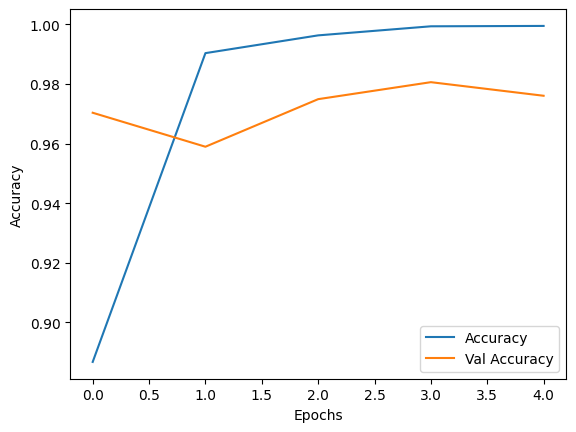

In [58]:
plt.plot(History.history['accuracy'] , label = 'Accuracy')
plt.plot(History.history['val_accuracy'] , label = 'Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

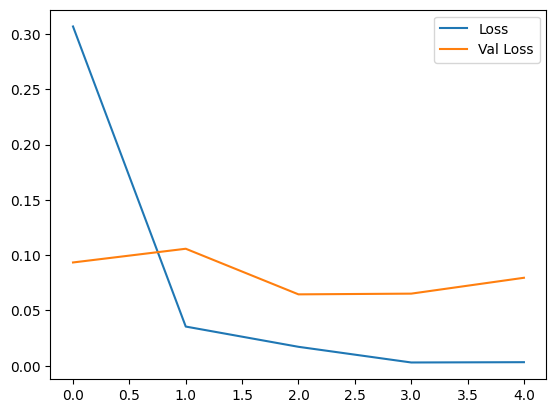

In [59]:
plt.plot(History.history['loss'] , label = 'Loss')
plt.plot(History.history['val_loss'] , label = 'Val Loss')
plt.legend()
plt.show()

### Semi-Supervised learning - For the rest of 70% data

In [60]:
def semi_supervised_learning(Model , unlabeled_data , Num_iter, No_of_samples, X_train, y_train):
    
    for i in range(Num_iter):
    
        random_start = random.randint(0, len(unlabeled_data)-No_of_samples)
        random_range = list(range(random_start, random_start+No_of_samples))

        Data = unlabeled_data[random_range[0]:random_range[len(random_range)-1]]

        # Predict on unlabeled data
        Pad_seq = np.array([a[0][0] for a in Data.values])
#         print(Pad_Seq.shape)
        Pred = Model.predict(Pad_seq)
        Y_pred = [1 if float(a) > 0.5 else 0 for a in Pred]

        # Convert to data from and concatenate with 
        df = pd.DataFrame(columns=['Emails', 'Labels'])
        df['Emails'] = Data
        df['Labels'] = Y_pred
        print(df)
        X_labeled_train = pd.concat([X_train, df['Emails']], axis=0)
        y_labeled_train = pd.concat([y_train, df['Labels']], axis=0)
        

        # Now we will train the model again with labled + psuedo labels(unlabeled data)

        Seq =  np.array([a[0] for a in X_labeled_train])
        Model.fit(Seq , y_labeled_train , validation_split=0.1 , epochs = 1 , batch_size = 64)
        return Model

In [62]:
m = semi_supervised_learning(Model, X_unlabeled_test, 2, 200, X_labeled_train, y_labeled_train)
y_pred = m.predict(y_orig)
y_pred = [1 if float(a) > 0.5 else 0 for a in y_pred]
cm=confusion_matrix(y_orig,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
print(cm)

                                                 Emails  Labels
6756  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       0
6757  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6758  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6759  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6760  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
...                                                 ...     ...
6950  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6951  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6952  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       0
6953  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       1
6954  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       0

[199 rows x 2 columns]
  6/126 [>.............................] - ETA: 6:03 - loss: 0.0011 - accuracy: 1.0000

KeyboardInterrupt: 

In [63]:
m

[[    0 15352]
 [13854     0]]


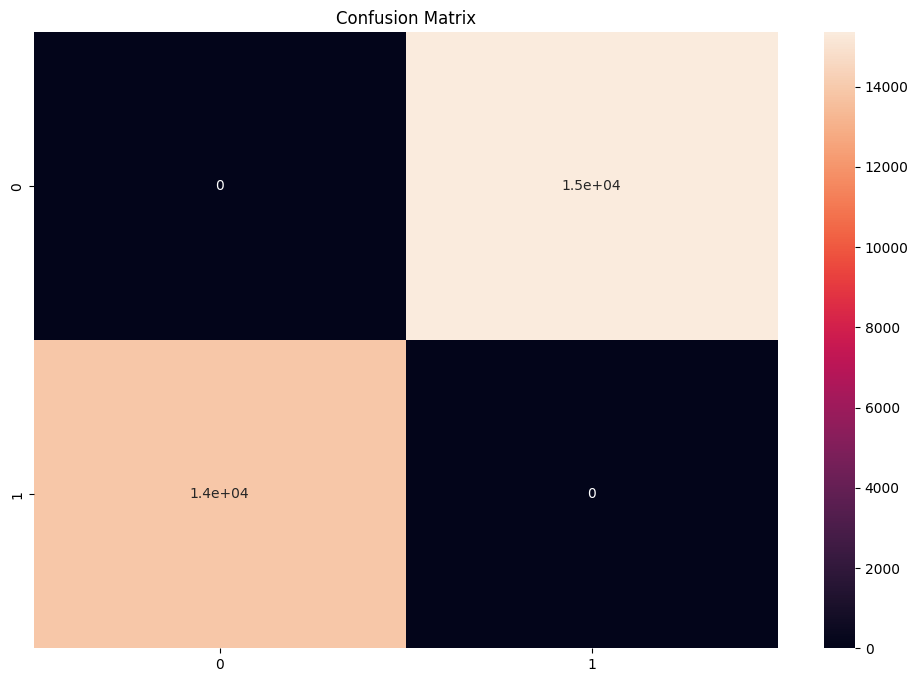

In [64]:
y_pred = m.predict(y_orig)
y_pred = [1 if float(a) > 0.5 else 0 for a in y_pred]
cm=confusion_matrix(y_orig,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
print(cm)